# Chapter 3: Time series decomposition

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

In [2]:
import calendar

from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import STL, seasonal_decompose

It's often helpful to decompose a time series into several components, each representing a different underlying pattern category. We can combine the trend and cycle into a single **trend-cycle** component which is often just called the trend for simplicity. Thus we can think of a time series as having three components: a trend-cycle component, seasonal components, and a remainder component. 

When decomposing a time series, it's sometimes helpful to transform or adjust the series to make the decomposition as simple as possible. 

## 3.1 Transformations and adjustments

Four kinds of adjustments:
- calendar
- population
- inflation
- mathematical transformations

The purpose of these is to simplify the patterns in the series by removing known sources of variation, or by making the pattern more consistent across the series. Simpler patterns are usually easier to model and lead to better forecasts. 

### Calendar adjustments 

Some of the variation in seasonal data may be due simply to calendar effects. It's usually easier to remove the variation before doing further analysis.

For example, when looking at total monthly sales in a retail store, there will be variation from month to month simply because of the different number of weekdays in each month in addition to seasonal variation across the year, holidays, etc. We can remove this variation by computing *average sales per trading day* in each month, rather than total sales in the month. This effectively removes the calendar variation. 

### Population adjustments

Data affected by population can be adjusted to give per-capita values. 

Consider the `global_economy` dataset, where we can plot Australian GDP per-capita instead of raw GDP. 

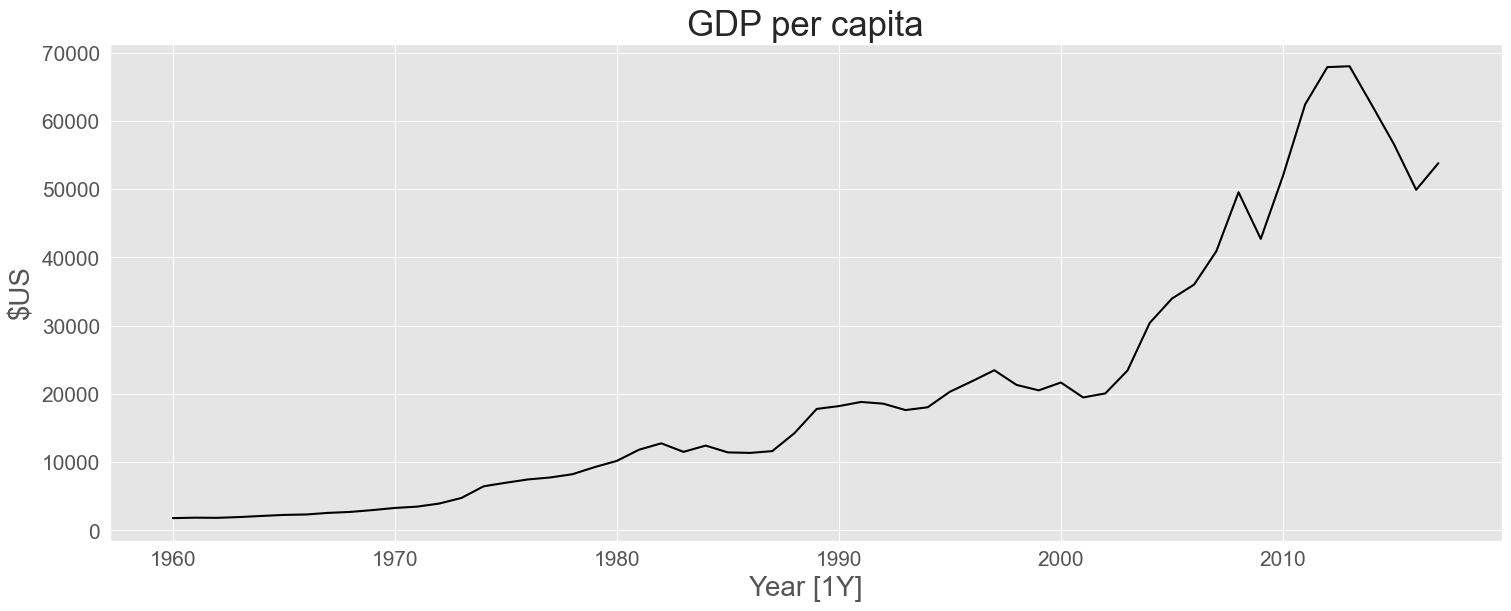

In [4]:
global_economy = pd.read_csv("./data/global_economy.csv")

df = (
    global_economy
    .loc[lambda x: x["unique_id"] == "Australia"]
    .assign(y=lambda x: x["GDP"] / x["Population"])
)
plot_series(df, xlabel="Year [1Y]", ylabel="$US", title="GDP per capita")

### Inflation adjustments 

Data affected by the value of money are best adjusted before modeling. For example, the average cost of a house will have increased over the last few decades due to inflation.

To make these adjustments, a price index is used. If $z_t$ denotes the price index and $y_t$ the original house price in year $t$, then $x_t = y_t / z_t * z_{2000}$ gives the adjusted house price at year 2000 dollar values. 

Consider looking at aggregate annual "newspaper and book" retail turnover from `aus_retail`, and adjusting the data for inflation using the CPI from `global_economy` as below.

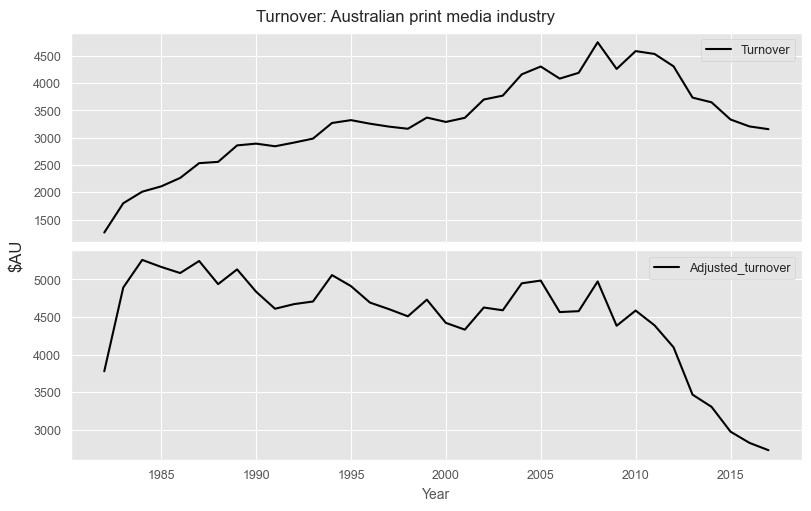

In [5]:
aus_retail = pd.read_csv("./data/aus_retail.csv", parse_dates=["Month"])
print_retail = (
    aus_retail
    .loc[lambda x: x["Industry"] == "Newspaper and book retailing"]
    .assign(ds=lambda x: x["Month"].dt.year)
    .groupby("ds", as_index=False)
    ["Turnover"].sum()
)

aus_economy = global_economy.loc[lambda x: x["unique_id"] == "Australia"]
df = (
    aus_economy
    .merge(print_retail, on="ds", how="left")
    .assign(adjusted_turnover=lambda x: x["Turnover"] / x["CPI"] * 100)
    .dropna()
)

fig, axes = plt.subplots(2, 1, sharex=True)
sns.lineplot(data=df, x='ds', y='Turnover', ax=axes[0],
    color='black', label="Turnover")
sns.lineplot(data=df, x='ds', y='adjusted_turnover', ax=axes[1],
    color='black', label="Adjusted_turnover")
axes[0].set(ylabel="")
axes[1].set(ylabel="", xlabel='Year')
fig.suptitle("Turnover: Australian print media industry")
fig.supylabel("$AU")
plt.show()

This shows evidence that the industry has been in decline much longer than the original data suggests. 

### Mathematical Transformations

- logarithmic transformation
    - interpretable: changes in a log value are percentage changes on the original scale. For example, if $\log_10$ is used, then an increase of 1 on the log scale corresponds to a multiplication by 10 on the original scale. 
- power transformations $w_t = (y_t)^p$
- **Box-Cox transformations** that depend on a parameter $\lambda$:
    - $$ w_t =
        \begin{cases}
            \ln(y_t) &\qquad \text{ if } \lambda =0, \\
            \frac{\text{sign}(y_t)|y_t|^\lambda - 1}{\lambda} &\qquad \text{ otherwise.}
        \end{cases}
        $$
    - A good value of $\lambda$ is one which makes the size of the seasonal variation about the same across the whole series. See Guerrero (1993) for a method on choosing $\lambda$.
    - Consider the following Box-Cox Transformation applied to `aus_production`. 

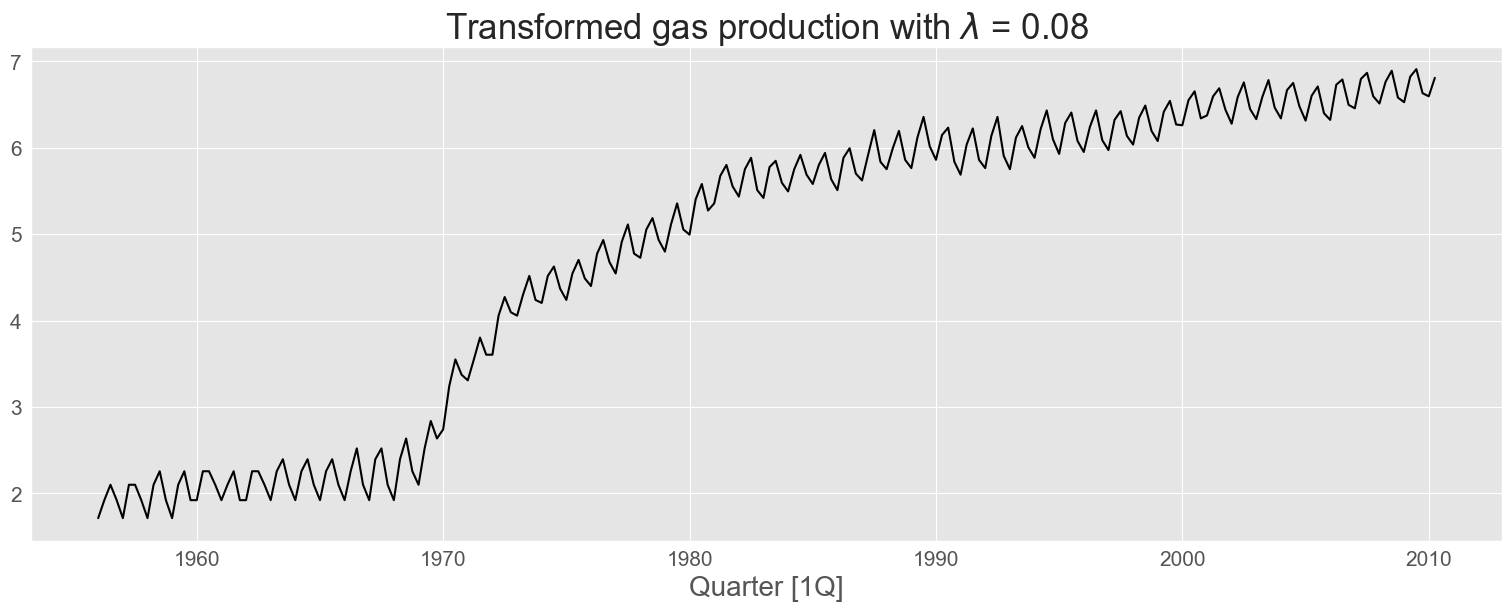

In [7]:
aus_production = pd.read_csv("./data/aus_production.csv",
    parse_dates=["ds"])
aus_gas = (
    aus_production[["ds", "Gas"]]
    .rename(columns={"Gas": "y"})
    .assign(unique_id="Gas")
)

y = aus_gas["y"].to_numpy()
optim_lambda = boxcox_lambda(y, method="guerrero", season_length=4)
df = aus_gas.assign(y_transformed=boxcox(y, optim_lambda))

title = rf"Transformed gas production with $\lambda$ = {optim_lambda:.2f}"
plot_series(df, target_col="y_transformed",
    xlabel="Quarter [1Q]", ylabel="", title=title)

### 3.2 Time series components

Assuming an additive decomposition, we can write $$y_t = S_t + T_t + R_t,$$ where $y$ is the data, $S$ is the seasonal component, $T$ is the trend-cycle component, and $R$ is the remainder component. An additive decomposition is appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, doesn't vary with the level of the time series. If the variation in seasonal pattern or variation around the trend-cycle appears proportional to the level of the series, a multiplicative decomposition is more appropriate (common with economic time series). 

### Example: Employment in the US retail sector

As an example, let's decompose the number of people employed in US retail below. The data shows the total monthly number of people in thousands employed in retail across the US since 1990.

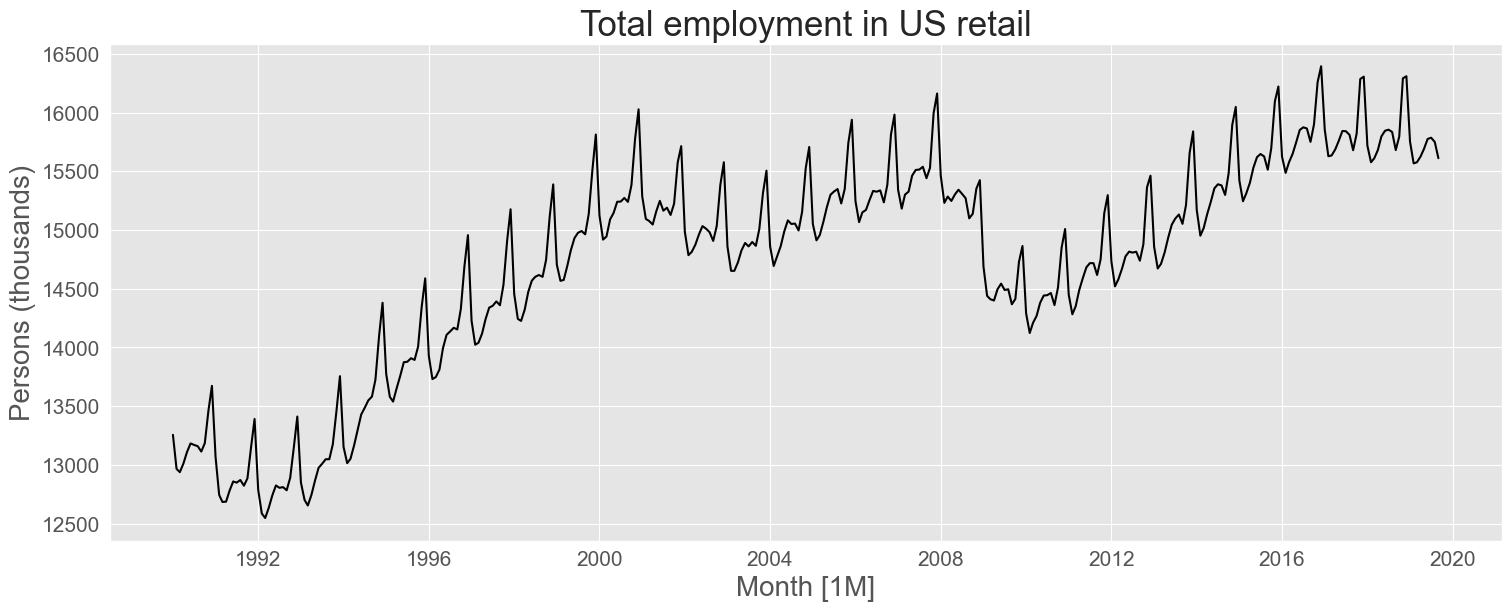

In [9]:
us_employment = pd.read_csv("./data/us_employment.csv", parse_dates=["ds"])
us_retail_employment = us_employment.loc[lambda x:
    (x["unique_id"] == "Retail Trade") & (x["ds"] >= "1990")
]

plot_series(us_retail_employment,
    xlabel="Month [1M]", ylabel="Persons (thousands)",
    title="Total employment in US retail")

We use the STL decomposition method, discussed in Section 3.6. 

In [10]:
stl = STL(us_retail_employment["y"], period=12)
res = stl.fit()

dcmp = pd.DataFrame({
    "ds": us_retail_employment["ds"],
    "data": us_retail_employment["y"],
    "trend": res.trend,
    "seasonal": res.seasonal,
    "remainder": res.resid,
}).reset_index(drop=True)

dcmp.head()

,ds,data,trend,seasonal,remainder
0,1990-01-01,13255.8,13296.249,-3.700,-36.749
1,1990-02-01,12966.3,13276.085,-288.398,-21.387
2,1990-03-01,12938.2,13255.663,-306.658,-10.805
3,1990-04-01,13012.3,13234.986,-235.775,13.089
4,1990-05-01,13108.3,13214.071,-115.399,9.628


The above dataframe shows the different estimated components of an STL decomposition. The `trend` column follows the overall movement of the series, ignoring seasonality and random fluctuations, as shown below. 

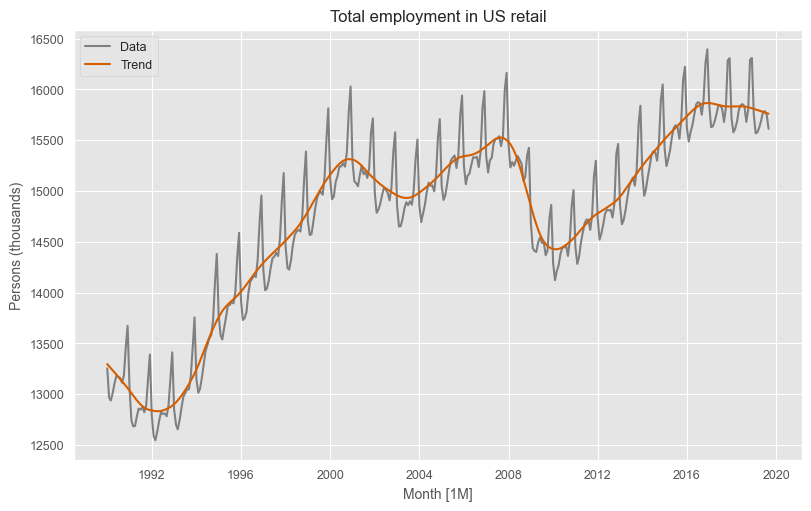

In [11]:
fig, ax = plt.subplots()
sns.lineplot(data=dcmp, x="ds", y="data", color="gray", label="Data")
sns.lineplot(data=dcmp, x="ds", y="trend", color="#D55E00", label="Trend")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

We can similarly plot all components of the decomposition as shown below.

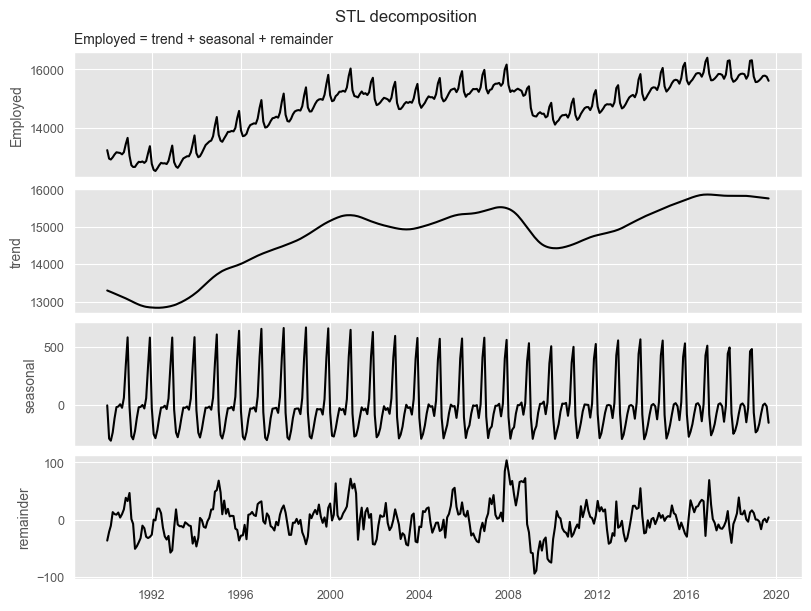

In [12]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
sns.lineplot(data=dcmp, x="ds", y="data", ax=axes[0])
sns.lineplot(data=dcmp, x="ds", y="trend", ax=axes[1])
sns.lineplot(data=dcmp, x="ds", y="seasonal", ax=axes[2])
sns.lineplot(data=dcmp, x="ds", y="remainder", ax=axes[3])
axes[0].set_title("Employed = trend + seasonal + remainder",
    size="medium", loc="left")
axes[0].set(ylabel="Employed")
axes[3].set(xlabel="")
fig.suptitle("STL decomposition")
plt.show()

Summing the three components in the bottom three panels produces the original time series in the top panel.

Note the change in the seasonal component over time.

### Seasonally adjusted data

If the seasonal component is removed, the resulting values are "seasonally adjusted". For an additive decomposition, the seasonally adjusted data is given by $$y_t - S_t.$$

Below shows the seasonally adjusted number of people employed. 

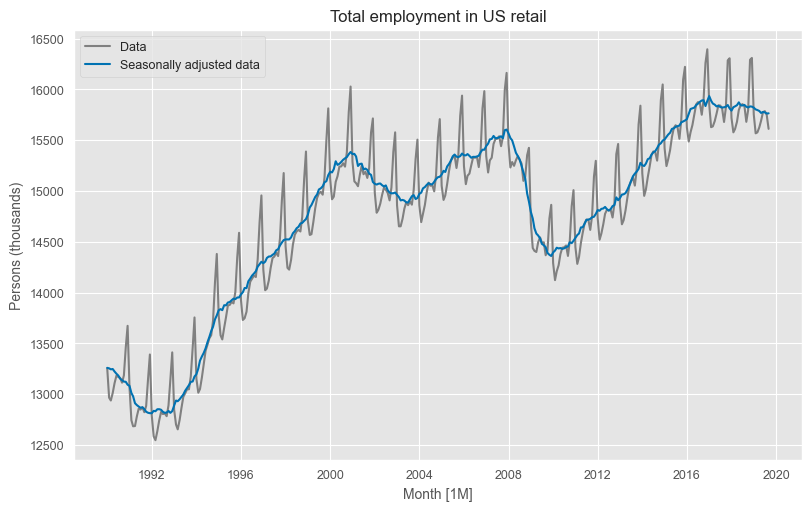

In [13]:
df = dcmp.assign(adj=lambda x: x["data"] - x["seasonal"])

fig, ax = plt.subplots()
sns.lineplot(data=df, x="ds", y="data",
    color="gray", label="Data")
sns.lineplot(data=df, x="ds", y="adj",
    color="#0072B2", label="Seasonally adjusted data")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

Employment data and many other economic series are usually seasonally adjusted since the seasonal variation is not of primary interest. 

### 3.3 Moving averages

The first step in a classical decomposition is to use a moving average method to estimate the trend cycle. 

### Moving average smoothing

A moving average of order $m$ can be written as $$ \hat{T}_t =\frac{1}{m}\sum_{j=-k}^{k} y_{t+j},$$ where $m=2k+1$. Thus the estimate of the trend cycle at time $t$ is obtained by averaging values of the time series that are within $k$ steps of $t$. 

Consider the below plot which show exports of goods and services for Australia as a percentage of GDP from 1960 to 2017. 

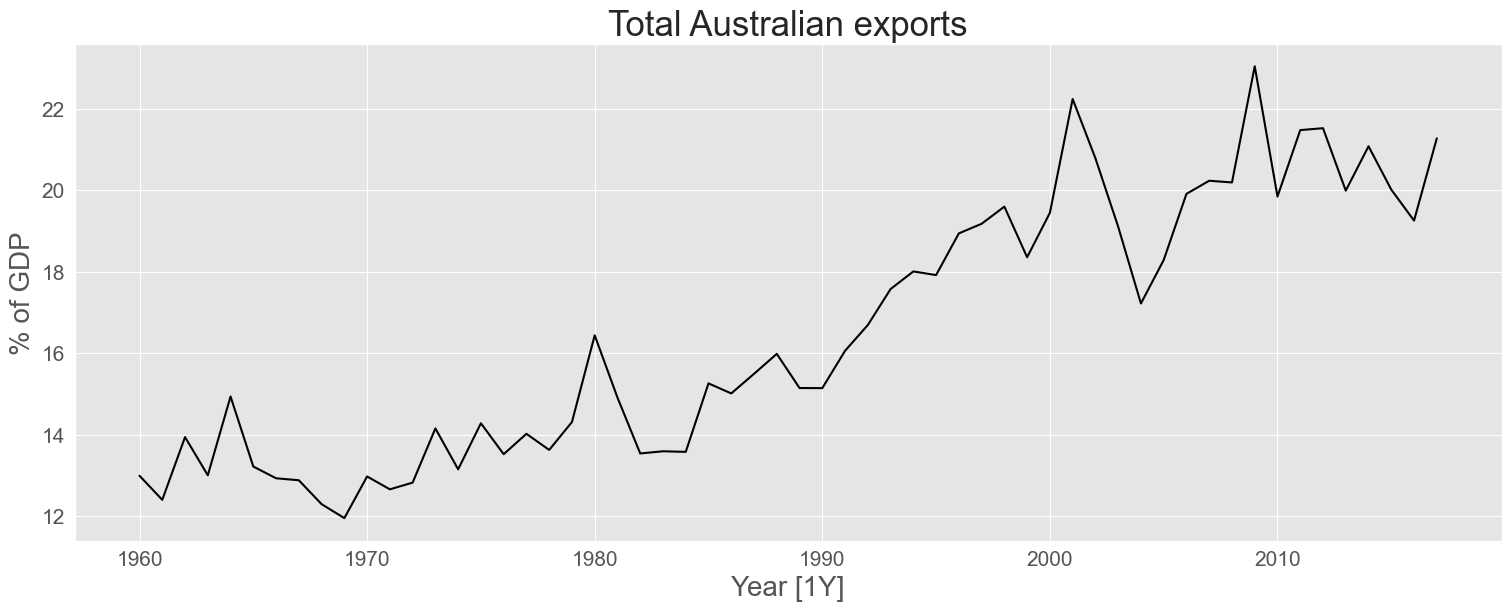

In [18]:
global_economy = pd.read_csv("./data/global_economy.csv")
df = global_economy.loc[lambda x: x["unique_id"] == "Australia"]

plot_series(df, target_col="Exports",
    xlabel="Year [1Y]", ylabel="% of GDP",
    title="Total Australian exports")

Let's look at the 5-year MA for this data. 

In [19]:
aus_exports = (
    global_economy
    .loc[lambda x: x["unique_id"] == "Australia"]
    .assign(MA_5=lambda x: x["Exports"].rolling(5, center=True).mean())
)

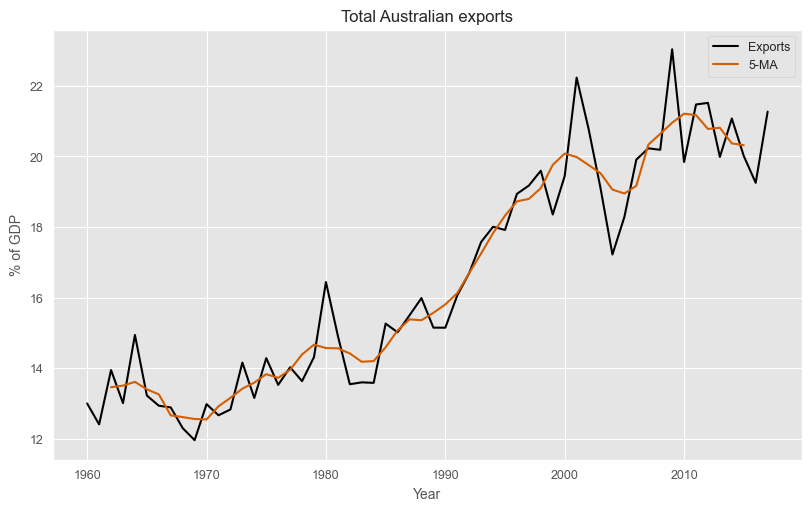

In [20]:
fig, ax = plt.subplots()
sns.lineplot(data=aus_exports, x="ds", y="Exports",
    color="black", label="Exports")
sns.lineplot(data=aus_exports, x="ds", y="MA_5",
    color="#D55E00", label="5-MA")
ax.set(
    title="Total Australian exports",
    xlabel="Year",
    ylabel="% of GDP",
)
plt.show()

### Moving averages of moving averages

We might take a moving average of order 4, then apply another moving average of order 2 to that. In the following, we do this for the first few years of the Australian quarterly beer production data. 

In [22]:
aus_production = pd.read_csv("./data/aus_production.csv",
    parse_dates=["ds"])
beer = (
    aus_production[["ds", "Beer"]]
    .loc[lambda x: x["ds"] >= "1992"]
    .reset_index(drop=True)
)
beer["4-MA"] = beer["Beer"].rolling(4, center=True).mean().shift(-1)
beer["2x4-MA"] = beer["4-MA"].rolling(2, center=True).mean()

In [24]:
beer.head(10)

,ds,Beer,4-MA,2x4-MA
0,1992-01-01,443,NaN,NaN
1,1992-04-01,410,451.25,NaN
2,1992-07-01,420,448.75,450.000
3,1992-10-01,532,451.50,450.125
4,1993-01-01,433,449.00,450.250
5,1993-04-01,421,444.00,446.500
6,1993-07-01,410,448.00,446.000
7,1993-10-01,512,438.00,443.000
8,1994-01-01,449,441.25,439.625
9,1994-04-01,381,446.00,443.625


The notation "2x4-MA" means a 4-MA followed by a 2-MA. When a 2-MA follows a moving average of even order, it's called a "centered moving average of order 4", since the results are now symmetric. In general, an even order MA should be followed by an even order MA to make it symmetric about each $y_t$, and similarly for odd. 

### Estimating the trend cycle with seasonal data

The most common use of centered moving averages is for estimating the trend-cycle from seasonal data. 

Consider the 2x4-MA:
$$
\begin{aligned}
    \hat{T}_t &= \frac{1}{2}\left(\frac{1}{4}(y_{t-2} + y_{t-1} + y_t + y_{t+1}) +  \frac{1}{4}(y_{t-1} + y_{t} + y_{t+1} + y_{t+2})\right)\\
    &= \frac{1}{8}y_{t-2} + \frac{1}{4}y_{t-1} + \frac{1}{4}y_{t} + \frac{1}{4}y_{t+1} + \frac{1}{8}y_{t+2}
\end{aligned}
$$

When applied to quarterly data, each quarter is given equal weight of 1/4 since the first and last terms apply to the same quarter in consecutive years. Thus the seasonal variation will be averaged out. A similar effect would be obtained using a 2x4k-MA to quarterly data. 

In general, a 2xm-MA is equivalent to a weighted moving average of order $m+1$ where all observations take the weight 1/m except the first and last which take weights 1/2m. If the seasonal period is even of order $m$, we use a 2xm-mA to estimate the trend cycle. If the seasonal period is odd of order $m$, use an m-MA to estimate it. 

Other choices for the order of the MA usually result in trend-cycle estimates being contaminated by seasonality. 

### Example: Employment in the US retail sector

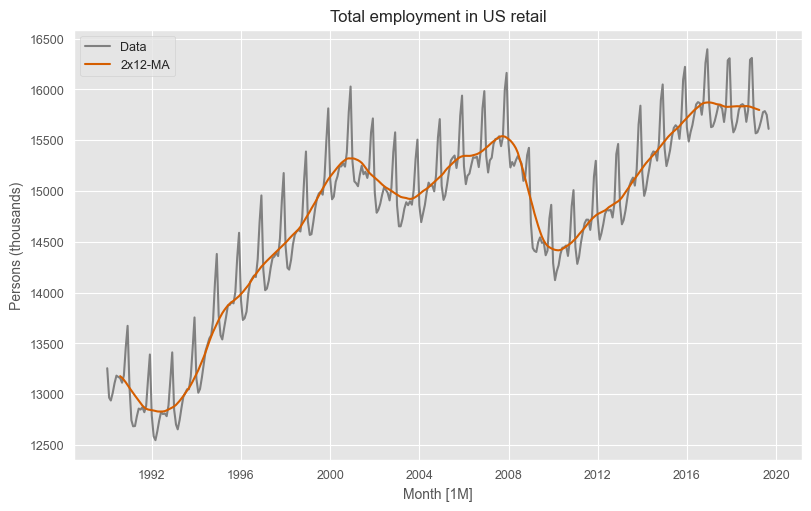

In [25]:
df = us_retail_employment.copy()
df["12-MA"] = df["y"].rolling(window=12, center=True).mean()
df["2x12-MA"] = df["12-MA"].rolling(window=2, center=True).mean()

fig, ax = plt.subplots()
sns.lineplot(data=df, x="ds", y="y",
    color="grey", label="Data")
sns.lineplot(data=df, x="ds", y="2x12-MA",
    color="#D55E00", label="2x12-MA")
ax.set(
    title="Total employment in US retail",
    xlabel="Month [1M]",
    ylabel="Persons (thousands)",
)
plt.show()

The above plot uses a 2x12-MA applied to monthly employment in US retail. The smooth line has no seasonality, and is almost the same as the trend-cycle shown above that was estimated using a more sophisticated decomposition technique (STL) than a moving average. Any other choice of order (except for multiples of 12) would have shown some seasonality. 

### Weighted moving averages

The 2x4-MA shown above is equivalent to a weighted 5-MA with weights 1/8, 1/4, 1/4, 1/4, 1/8.

It's important that the weights sum to 1 and that they're symmetric. The simple $m$-MA is a special case where all the weights equal 1/m. 

A major advantage of weighted MAs is that they yield a smoother estimate of the trend-cycle if the weights are smaller at the ends. 

## 3.4 Classical decomposition